In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
#Choose the ticker symbol for which you want the options data
ticker_str = "GME"

ticker = yf.Ticker(ticker_str)

# List of all expiration dates
expirations = ticker.options
print(expirations)

all_calls = []
all_puts = []

for exp in expirations:
    opt = ticker.option_chain(exp)
    
    # Create new column expiradionDate
    calls = opt.calls.copy()
    calls['expirationDate'] = exp
    all_calls.append(calls)
    
    puts = opt.puts.copy()
    puts['expirationDate'] = exp
    all_puts.append(puts)

# Group calls and puts in dataframes
calls_df = pd.concat(all_calls)
puts_df = pd.concat(all_puts)

# Open Interest for Calls grouped by strike und expiration date
oi_calls = calls_df.groupby(['expirationDate', 'strike'])['openInterest'].sum().reset_index()
oi_calls = oi_calls.rename(columns={'openInterest': 'openInterest_calls'})

# Open Interest for Puts grouped by strike und expiration date
oi_puts = puts_df.groupby(['expirationDate', 'strike'])['openInterest'].sum().reset_index()
oi_puts = oi_puts.rename(columns={'openInterest': 'openInterest_puts'})

# Merge to see both Calls and Puts together by strike and expiration date
oi_per_strike_exp = pd.merge(oi_calls, oi_puts, on=['expirationDate', 'strike'], how='outer').fillna(0)

print(oi_per_strike_exp)

('2025-07-03', '2025-07-11', '2025-07-18', '2025-07-25', '2025-08-01', '2025-08-08', '2025-08-15', '2025-10-17', '2026-01-16', '2026-06-18', '2027-01-15', '2027-12-17')
    expirationDate  strike  openInterest_calls  openInterest_puts
0       2025-07-03    10.0                15.0              202.0
1       2025-07-03    11.0                 2.0                0.0
2       2025-07-03    12.0                 3.0                0.0
3       2025-07-03    13.0                 5.0                0.0
4       2025-07-03    14.0                 2.0               10.0
..             ...     ...                 ...                ...
507     2027-12-17    45.0               285.0               10.0
508     2027-12-17    47.0                77.0               17.0
509     2027-12-17    50.0             12569.0                7.0
510     2027-12-17    55.0              3192.0               43.0
511     2027-12-17    60.0               859.0               15.0

[512 rows x 4 columns]


In [3]:
# Example filter for 1 expirationDate = "2025-07-18"
filtered_df = oi_per_strike_exp[oi_per_strike_exp['expirationDate'] == "2025-07-18"]

print(filtered_df)

    expirationDate  strike  openInterest_calls  openInterest_puts
132     2025-07-18     3.0                 5.0               18.0
133     2025-07-18     4.0                 4.0                1.0
134     2025-07-18     5.0                 2.0                5.0
135     2025-07-18     6.0                 0.0               19.0
136     2025-07-18     7.0                 2.0                0.0
137     2025-07-18     8.0                 1.0              156.0
138     2025-07-18     9.0                67.0                1.0
139     2025-07-18    10.0               111.0              675.0
140     2025-07-18    11.0                 1.0              463.0
141     2025-07-18    12.0                16.0               46.0
142     2025-07-18    13.0                27.0               45.0
143     2025-07-18    14.0                15.0              157.0
144     2025-07-18    15.0               739.0             1044.0
145     2025-07-18    16.0               100.0              537.0
146     20

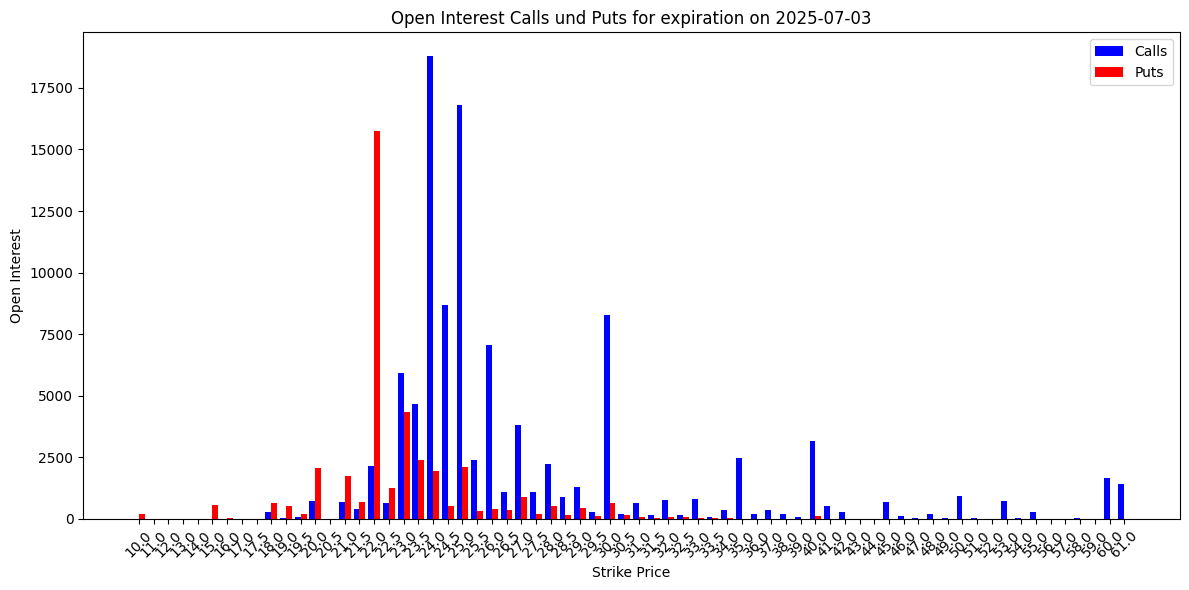

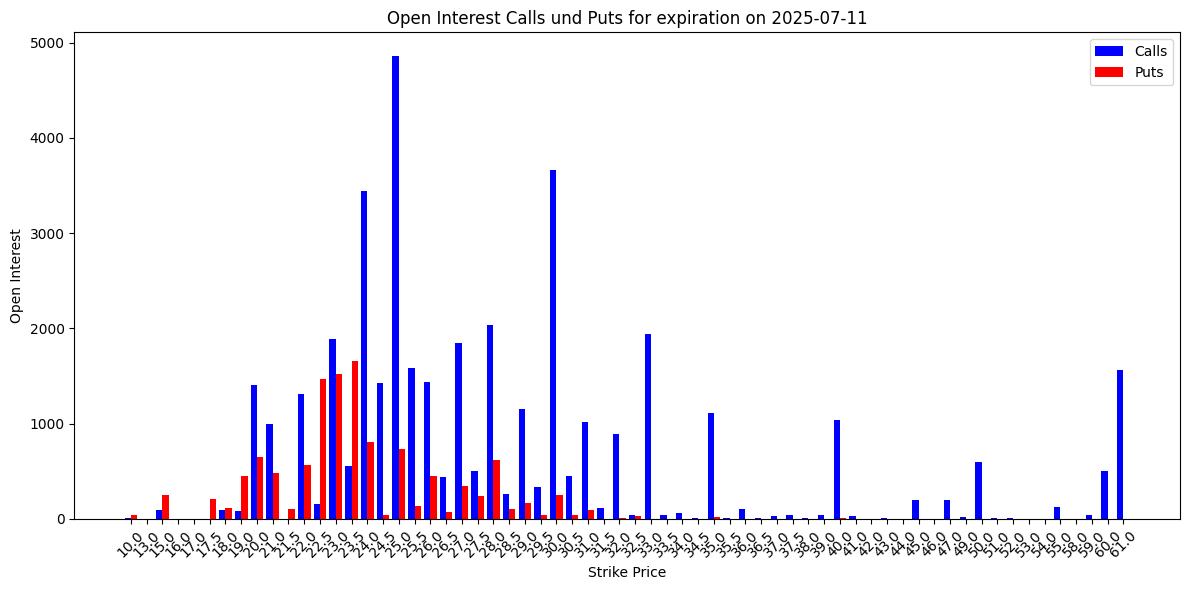

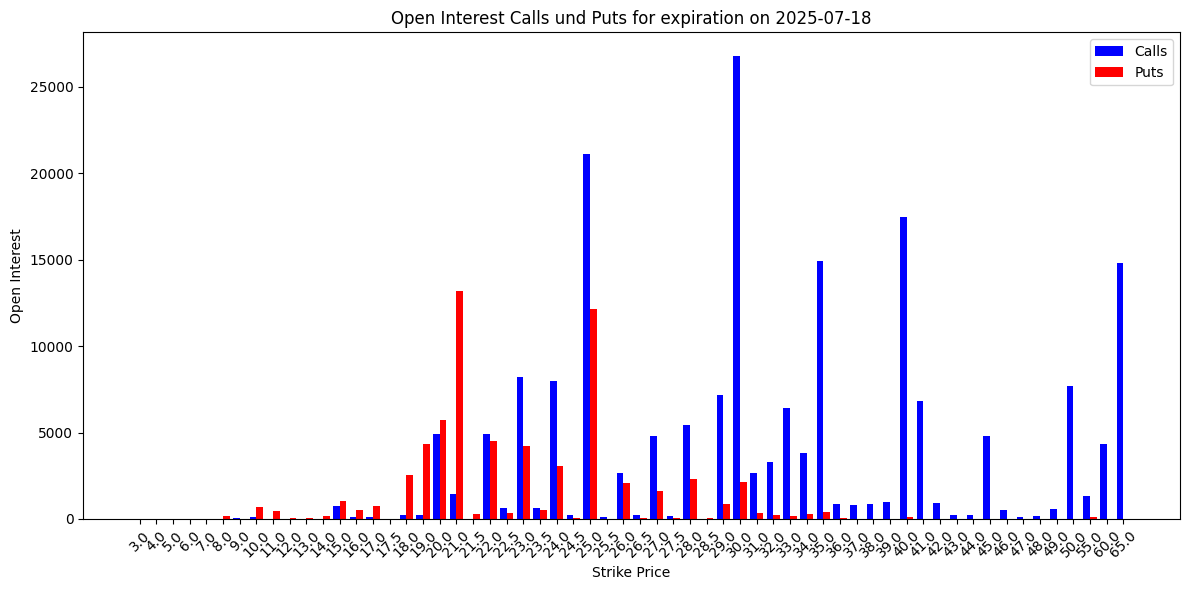

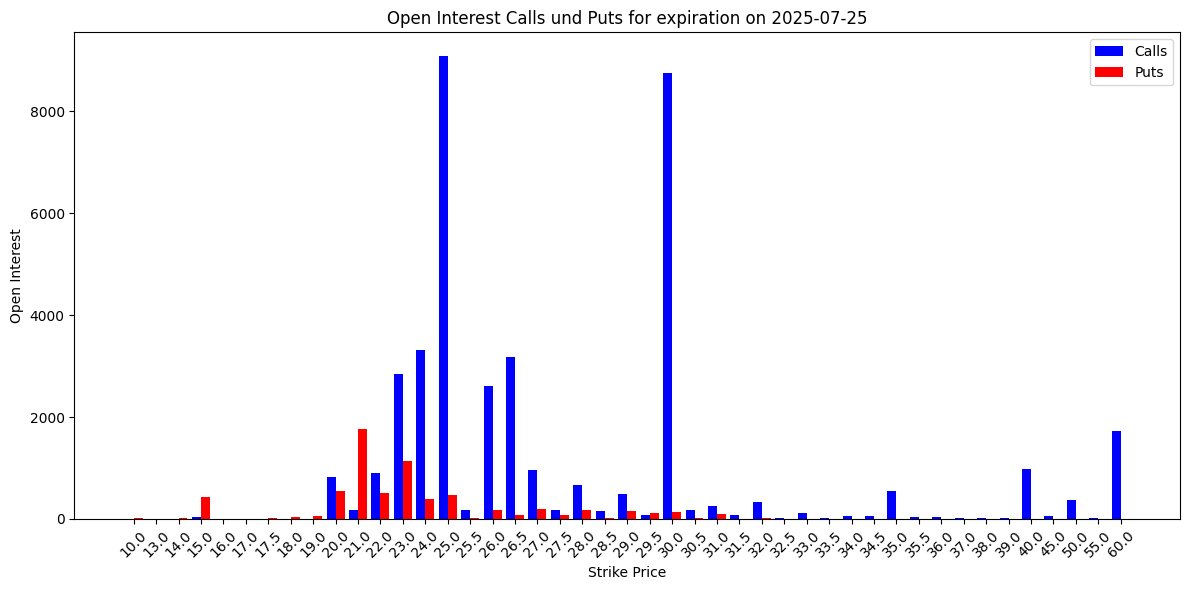

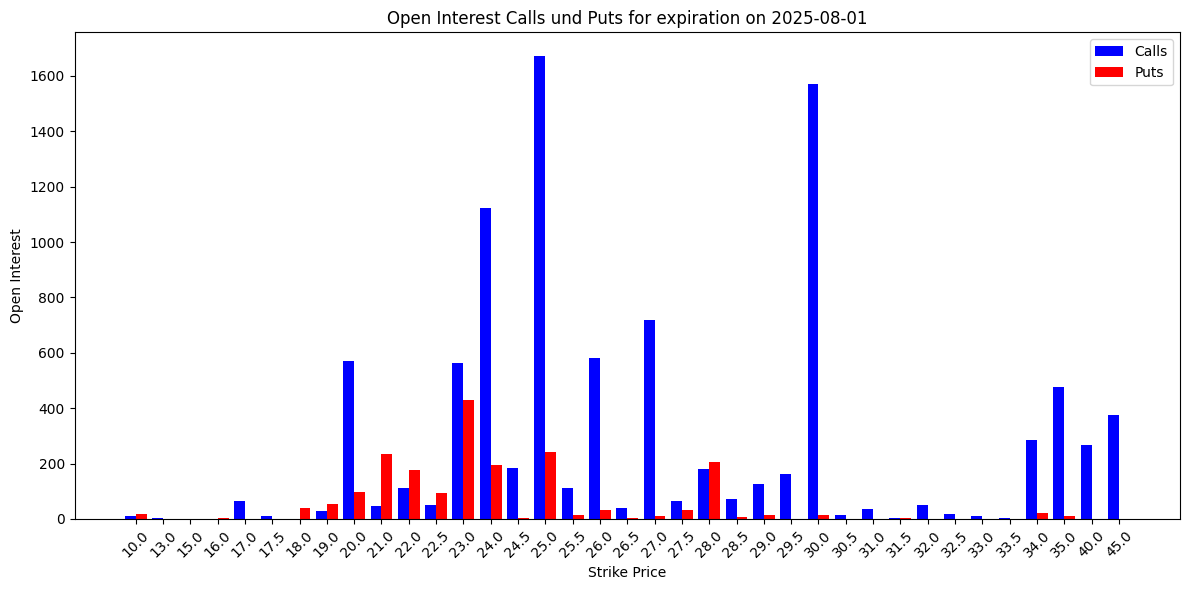

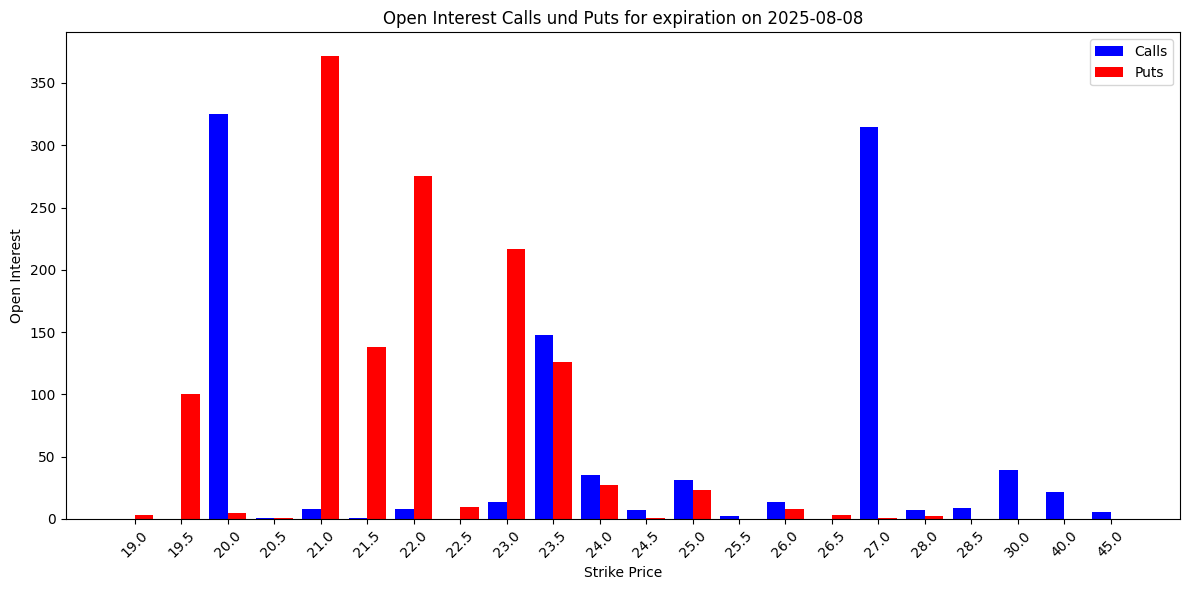

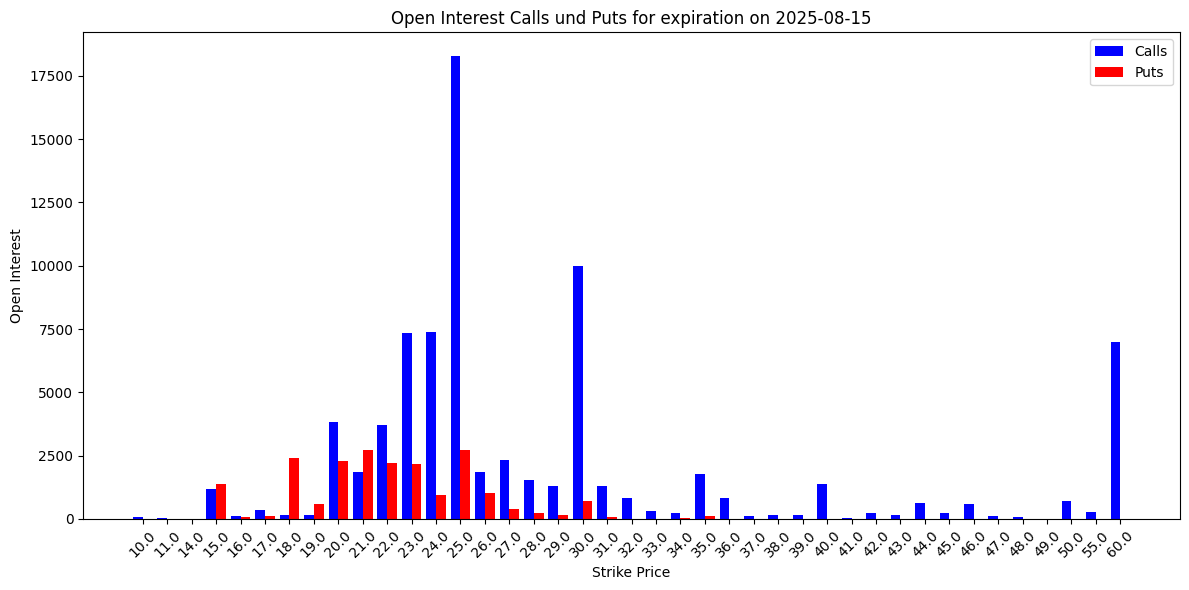

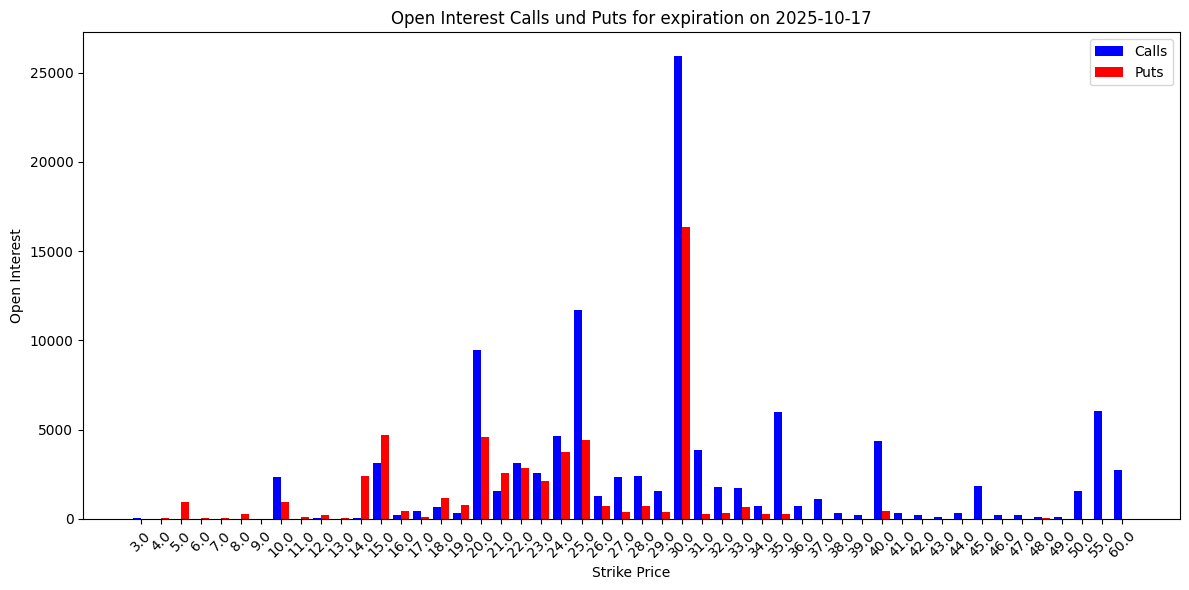

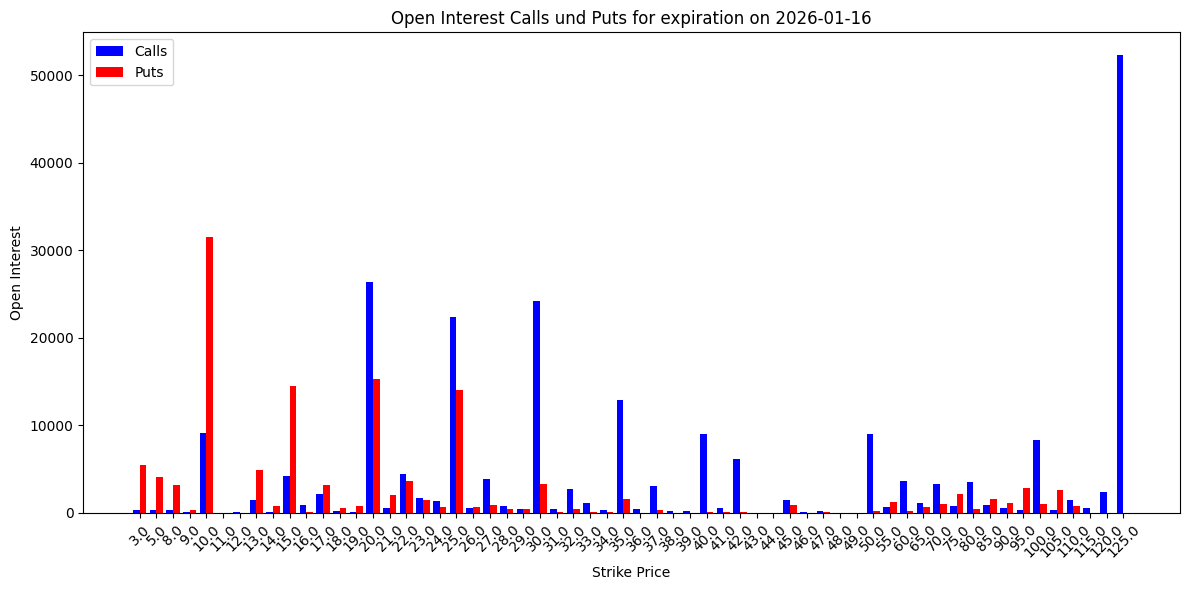

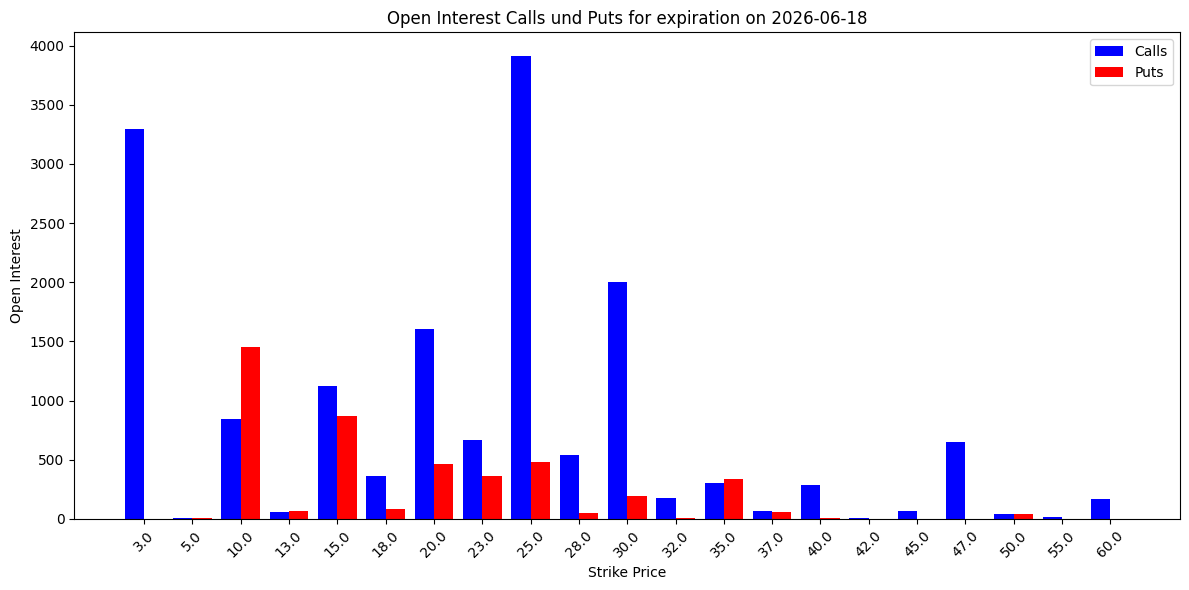

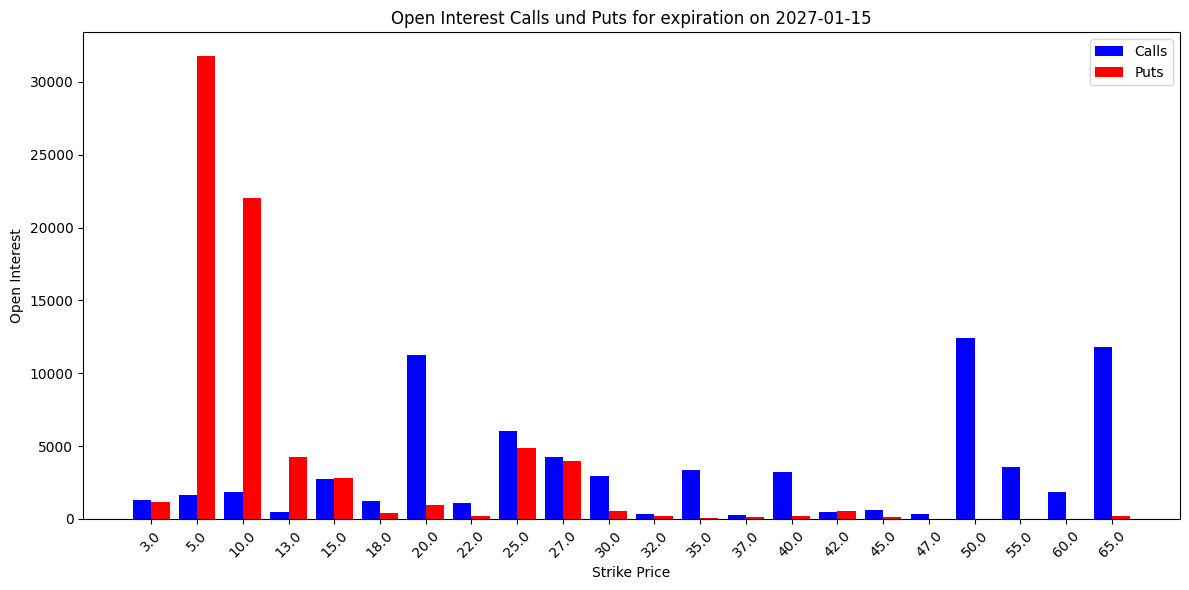

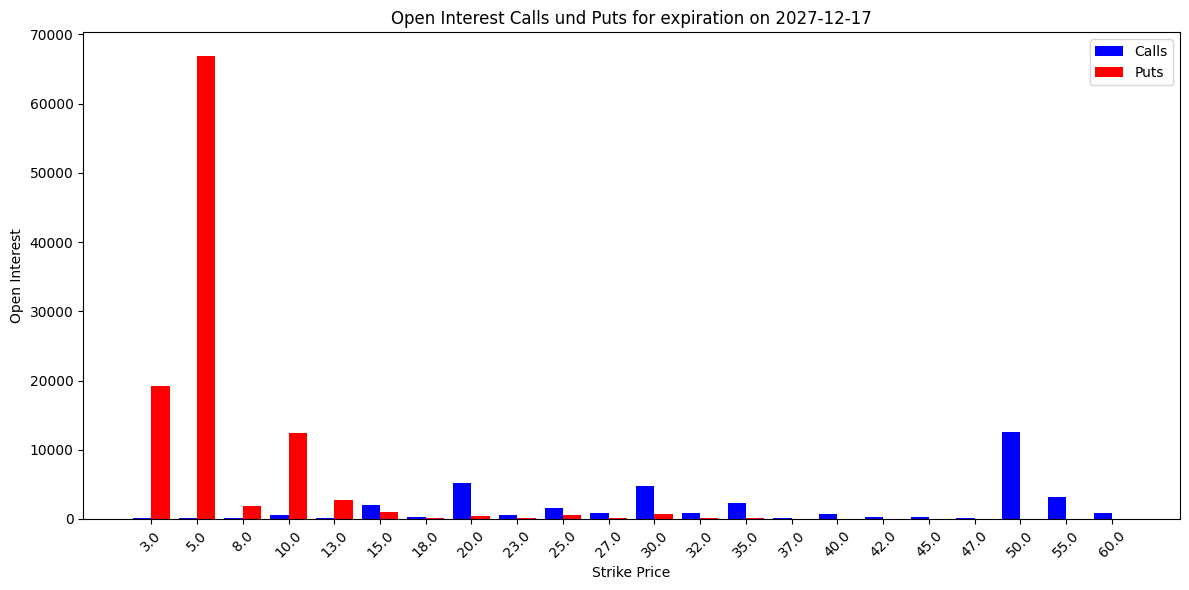

In [4]:
#Code to print plots in console

# Assumption: oi_per_strike_exp is the DataFrame with columns:
# 'expirationDate', 'strike', 'openInterest_calls', 'openInterest_puts'

# All unique expiration dates
expiration_dates = oi_per_strike_exp['expirationDate'].unique()

for exp_date in expiration_dates:
    # filter data for current expirationDate
    df_filtered = oi_per_strike_exp[oi_per_strike_exp['expirationDate'] == exp_date]
    
    # sort by strike
    df_filtered = df_filtered.sort_values('strike')
    
    strikes = df_filtered['strike']
    calls = df_filtered['openInterest_calls']
    puts = df_filtered['openInterest_puts']
    
    # bar width
    width = 0.4
    
    # position on x-axis
    x = range(len(strikes))
    
    plt.figure(figsize=(12,6))
    
    # plot Call bars (links)
    plt.bar([pos - width/2 for pos in x], calls, width=width, label='Calls', color='blue')
    
    # plot Put bars (rechts)
    plt.bar([pos + width/2 for pos in x], puts, width=width, label='Puts', color='red')
    
    plt.xlabel('Strike Price')
    plt.ylabel('Open Interest')
    plt.title(f'Open Interest Calls und Puts for expiration on {exp_date}')
    plt.xticks(ticks=x, labels=strikes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
#Code to save plots in a subfolder, with adjustments made on the plots (OI per strike on the graph, if above threshold; only print strikes on x-axis, 
#above threshold)

# Assumption: oi_per_strike_exp is the DataFrame with columns:
# 'expirationDate', 'strike', 'openInterest_calls', 'openInterest_puts'

output_dir = f'plots/{ticker_str}/'
os.makedirs(output_dir, exist_ok=True)

expiration_dates = oi_per_strike_exp['expirationDate'].unique()

# Threshold for open interest (Choose dependant on the typical OI on your ticker - for "GME" 1000 seems reasonable)
oi_threshold = 1000

for exp_date in expiration_dates:
    df_filtered = oi_per_strike_exp[oi_per_strike_exp['expirationDate'] == exp_date]
    df_filtered = df_filtered.sort_values('strike')
    
    strikes = df_filtered['strike'].values
    calls = df_filtered['openInterest_calls'].values
    puts = df_filtered['openInterest_puts'].values
    
    width = 0.4
    x = np.arange(len(strikes))
    
    plt.figure(figsize=(12,6))
    bars_calls = plt.bar(x - width/2, calls, width=width, label='Calls', color='blue')
    bars_puts = plt.bar(x + width/2, puts, width=width, label='Puts', color='red')
    
    plt.xlabel('Strike Price')
    plt.ylabel('Open Interest')
    plt.title(f'"{ticker_str}" Open Interest Calls and Puts for expiration on {exp_date}')
    
    # Total Open Interest (Calls + Puts)
    total_oi = calls + puts
    
    # Only label strikes above threshold
    strike_labels = []
    for i, oi in enumerate(total_oi):
        if oi > oi_threshold:
            strike_labels.append(str(strikes[i]))
        else:
            strike_labels.append('')  # Empty Label 
    
    plt.xticks(ticks=x, labels=strike_labels, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Optional: label bars above threshold
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            if height > oi_threshold:
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=8, color='black'
                )
    autolabel(bars_calls)
    autolabel(bars_puts)
    
    filename = f'open_interest_{exp_date}.png'
    filepath = os.path.join(output_dir, filename)
    
    plt.savefig(filepath)
    plt.close()

print(f'All plots were saved in path "{output_dir}"')

All plots were saved in path "plots/GME/"
